In [1]:
# Import required libraries
import pickle
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

%matplotlib inline

In [2]:
# Define the EEGRecording class
class EEGRecording:
    def __init__(self, eeg_data, recording_start_time, fs=512):
        self.data = eeg_data
        self.start_time = datetime.strptime(recording_start_time, "%Y-%m-%d %H:%M:%S")
        self.fs = fs
        
    def get_segment(self, segment_start_time, duration_mins):
        start_delta = datetime.strptime(segment_start_time, "%Y-%m-%d %H:%M:%S") - self.start_time
        start_idx = int(start_delta.total_seconds() * self.fs)
        n_samples = int(duration_mins * 60 * self.fs)
        return self.data[start_idx:start_idx + n_samples]

In [3]:
# Set your file paths and parameters
pickle_path = '/Volumes/harris/somnotate/to_score_set/pickle_eeg_signal/eeg_data_sub-016_ses-02_recording-01.pkl'
recording_start_time = '2024-11-29 13:29:18'
segment_start_time = '2024-11-30 13:30:00'
duration_mins = 90
fs = 512

In [4]:
# Load data
with open(pickle_path, 'rb') as f:
    data = pickle.load(f)

recording = EEGRecording(data['EEG1'], recording_start_time)
signal_segment = recording.get_segment(segment_start_time, duration_mins)

print(f"Signal segment length: {len(signal_segment)} samples")
print(f"Duration: {len(signal_segment) / fs / 60:.1f} minutes")

/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_22658/2853243845.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


Signal segment length: 2764800 samples
Duration: 90.0 minutes


In [5]:
# Compute spectrogram
nperseg = 512 * 2  # 2-second windows
f, t, Sxx = signal.spectrogram(signal_segment, 
                              fs=fs,
                              nperseg=nperseg,
                              noverlap=nperseg//2,
                              nfft=2048)

print(f"Frequency bins: {len(f)}")
print(f"Time bins: {len(t)}")
print(f"Spectrogram shape: {Sxx.shape}")

Frequency bins: 1025
Time bins: 5399
Spectrogram shape: (1025, 5399)


In [8]:
# Filter frequency range and convert to dB
mask = (f >= 1) & (f <= 64)
power_db = 10 * np.log10(Sxx[mask])

# Compute color limits with extreme percentiles for maximum contrast
vmin = np.percentile(power_db, 0.1)
vmax = np.percentile(power_db, 99.9)

print(f"Power range: {vmin:.2f} to {vmax:.2f} dB")
print(f"Filtered frequency range: {f[mask][0]:.2f} to {f[mask][-1]:.2f} Hz")

Power range: -24.17 to 30.04 dB
Filtered frequency range: 1.00 to 64.00 Hz


In [ ]:
# Enhanced contrast with more extreme percentiles
vmin_enhanced = np.percentile(power_db, 0.01)
vmax_enhanced = np.percentile(power_db, 99.99)

print(f"Enhanced power range: {vmin_enhanced:.2f} to {vmax_enhanced:.2f} dB")
print(f"Dynamic range: {vmax_enhanced - vmin_enhanced:.2f} dB")

fig, ax = plt.subplots(figsize=(16, 6))

plt.pcolormesh(t, f[mask], power_db,
               cmap='inferno',
               shading='gouraud',
               vmin=vmin_enhanced,
               vmax=vmax_enhanced)|

plt.yscale('log')
plt.yticks([1, 4, 16, 64], ['1', '4', '16', '64'], fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylim(1, 64)
ax.yaxis.set_minor_locator(plt.NullLocator())

# Add colorbar
cbar = plt.colorbar(label='Power (dB)')
cbar.ax.tick_params(labelsize=12)

plt.title(f'EEG Spectrogram - Enhanced Contrast (0.01–99.99 percentile)', fontsize=16)
plt.tight_layout()
plt.show()


Enhanced power range: -33.83 to 34.18 dB
Gamma correction: 0.9


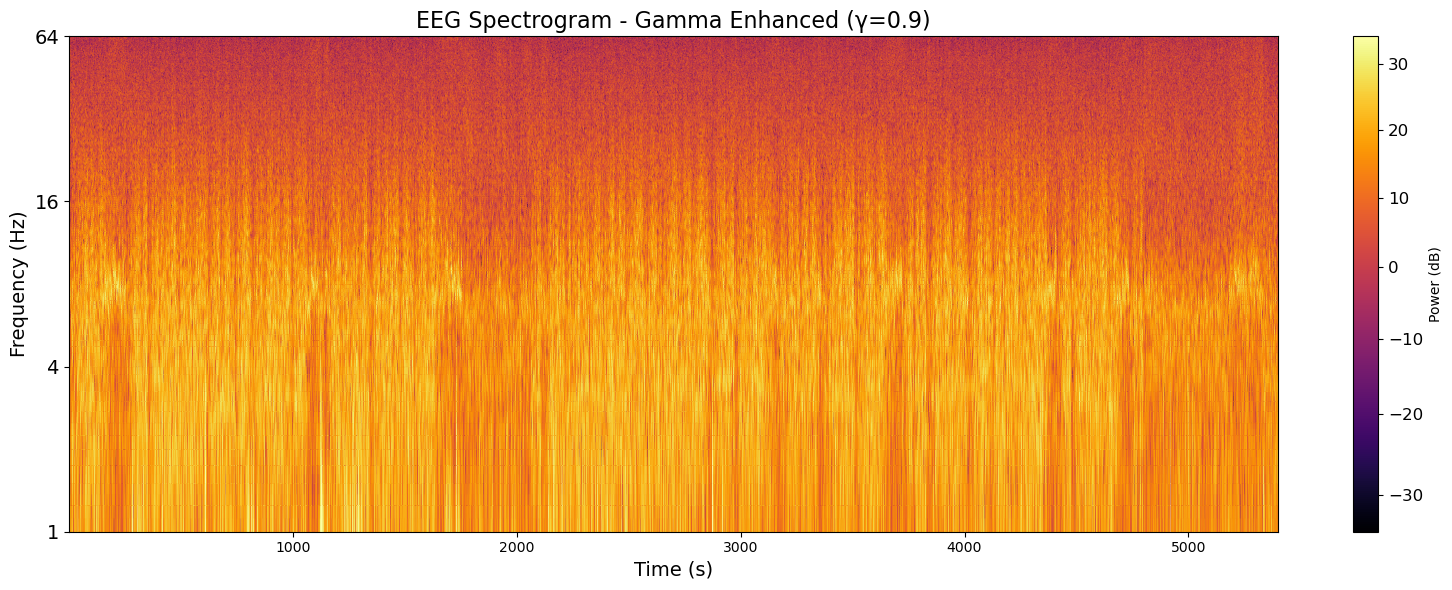

In [7]:
# Further enhance contrast with gamma correction
from matplotlib.colors import PowerNorm

vmin_enhanced = np.percentile(power_db, 0.01)
vmax_enhanced = np.percentile(power_db, 99.99)

# Gamma < 1 stretches mid-tones and shadows, gamma > 1 compresses them
gamma = 0.9  # Try 0.3-0.7 for extreme contrast

print(f"Enhanced power range: {vmin_enhanced:.2f} to {vmax_enhanced:.2f} dB")
print(f"Gamma correction: {gamma}")

fig, ax = plt.subplots(figsize=(16, 6))

plt.pcolormesh(t, f[mask], power_db,
               cmap='inferno',
               shading='gouraud',
               norm=PowerNorm(gamma=gamma, vmin=vmin_enhanced, vmax=vmax_enhanced))

plt.yscale('log')
plt.yticks([1, 4, 16, 64], ['1', '4', '16', '64'], fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylim(1, 64)
ax.yaxis.set_minor_locator(plt.NullLocator())

# Add colorbar
cbar = plt.colorbar(label='Power (dB)')
cbar.ax.tick_params(labelsize=12)

plt.title(f'EEG Spectrogram - Gamma Enhanced (γ={gamma})', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Fixed dynamic range for maximum contrast compression
from matplotlib.colors import PowerNorm

# Force a narrower dB window to compress the color range
dynamic_range_db = 50  # Try 30-50 dB

vmax_fixed = np.percentile(power_db, 99.99)
vmin_fixed = vmax_fixed - dynamic_range_db
gamma = 0.5

print(f"Fixed dynamic range: {dynamic_range_db} dB")
print(f"Color limits: {vmin_fixed:.2f} to {vmax_fixed:.2f} dB")

fig, ax = plt.subplots(figsize=(16, 6))

plt.pcolormesh(t, f[mask], power_db,
               cmap='inferno',
               shading='gouraud',
               norm=PowerNorm(gamma=gamma, vmin=vmin_fixed, vmax=vmax_fixed))

plt.yscale('log')
plt.yticks([1, 4, 16, 64], ['1', '4', '16', '64'], fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylim(1, 64)
ax.yaxis.set_minor_locator(plt.NullLocator())

cbar = plt.colorbar(label='Power (dB)')
cbar.ax.tick_params(labelsize=12)

plt.title(f'EEG Spectrogram - Fixed Range ({dynamic_range_db} dB, γ={gamma})', fontsize=16)
plt.tight_layout()
plt.show()
